<a href="https://colab.research.google.com/github/JorgeTabera/DataScienceII.CoderH/blob/main/Proyecto_Spotify_DS_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🎶 Proyecto: Análisis de Playlists de Spotify

Este proyecto tiene como objetivo **extraer datos de playlists de Spotify** utilizando su API, para luego analizarlos y obtener insights sobre tendencias musicales en Argentina.  
El flujo de trabajo se estructura en pasos claros: **conexión, autenticación, extracción y exploración de datos**.

---
---

###  Preguntas de interés

A lo largo del análisis, se buscará responder las siguientes preguntas para entender mejor las tendencias musicales en Arg:

- 🎧 ¿Qué artistas dominan el Top 50 actual?
- 📈 ¿Qué géneros musicales son más frecuentes en la playlist?
- 🌍 ¿Qué proporción de artistas son locales vs. internacionales?
- 🔥 ¿Qué canciones tienen mayor popularidad y por qué?
- 🧠 ¿Existe relación entre la popularidad del artista y la del track?
- 📅 ¿Los lanzamientos recientes tienen mayor presencia en el ranking?
- 🎶 ¿Qué géneros están asociados a mayor popularidad?

Estas preguntas orientan el análisis exploratorio y permiten construir visualizaciones y conclusiones relevantes para audiencias técnicas y ejecutivas.




## 📌 Bloque 1: Importación de librerías

In [1]:
import os
from google.colab import drive
import requests, base64
import pandas as pd
from IPython.display import Image, display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
#Estilo visual para graficos ↓
sns.set(style="whitegrid")




## 📌 Bloque 2: Montar Google Drive y leer credenciales

Para mantener las credenciales seguras, las guardamos en un archivo `.txt` dentro de Google Drive.  
Aquí montamos el Drive y accedemos al archivo que contiene el `CLIENT_ID` y `CLIENT_SECRET`, necesarios para generar el token de acceso.

> 📂 Ruta del archivo: `/MyDrive/CoderHouse/DataScienceII/SpotCredDSII.txt`


In [2]:
##Importamos Drive para trabajar con el Token de la API

drive.mount('/content/drive')

##Ingresamos al archivo que contiene las credenciales y lo importamos con variables:
cred_path = "/content/drive/MyDrive/CoderHouse/DataScienceII /SpotCredDSII.txt"

creds = {}
with open(cred_path) as f:
    for line in f:
        key, value = line.strip().split("=")
        creds[key] = value

CLIENT_ID = creds["CLIENT_ID"]
CLIENT_SECRET = creds["CLIENT_SECRET"]



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 📌 Bloque 3: Generar el token de acceso

Con las credenciales obtenidas, generamos el token de acceso mediante el flujo de `client_credentials`.  
Este token nos permite realizar consultas a la API de Spotify sin necesidad de autorización del usuario.

> 🔐 El token tiene una validez temporal y debe regenerarse en cada sesión.


In [3]:
## Ingresamos el token en la API

auth_str = f"{CLIENT_ID}:{CLIENT_SECRET}"
b64_auth = base64.b64encode(auth_str.encode()).decode()

headers = {
    "Authorization": f"Basic {b64_auth}",
    "Content-Type": "application/x-www-form-urlencoded"
}
data = {"grant_type": "client_credentials"}

try:
    r = requests.post("https://accounts.spotify.com/api/token", headers=headers, data=data)
    r.raise_for_status()
    TOKEN = r.json()["access_token"]
    print("✅ Conexión exitosa! Token generado:", TOKEN[:20], "...")
except Exception as e:
    print("❌ Verificar credenciales, no conectó")
    print("Error:", e)


✅ Conexión exitosa! Token generado: BQDh0Nr0tO9z650H0L6a ...


## 📌 Bloque 4: Extracción de datos de la playlist

En este paso consultamos una playlist pública de Spotify y extraemos los primeros 50 tracks disponibles.  
Para cada canción obtenemos información clave como:

- 🎵 Nombre del track  
- 👥 Artistas participantes  
- 📈 Popularidad (score de 0 a 100)  
- 💿 Álbum al que pertenece  
- 📅 Fecha de lanzamiento del álbum  
- 🆔 ID único del track  
- 🔗 URI interno de Spotify  
- 🖼️ Imagen del álbum (carátula en alta resolución)

Toda esta información se organiza en una tabla con columnas ordenadas, lo que permite visualizar y analizar fácilmente los atributos principales de cada canción.

> 🎧 Playlist utilizada: `"El Top 50 de Argentina"`  
> 🌎 Mercado: `"AR"`  
> 🔢 Límite: `50 tracks`  

Este paso nos permite construir una base sólida para el análisis musical, incluyendo visualización de carátulas, comparación de popularidad y perfil de artistas.


In [4]:
playlist_id = "7HOoKCy3TmkweeT9SskCxq"
url = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"

headers = {"Authorization": f"Bearer {TOKEN}"}
params = {"market": "AR", "limit": 50}

resp = requests.get(url, headers=headers, params=params)
resp.raise_for_status()
tracks = resp.json()


data = []
for idx, item in enumerate(tracks["items"], start=1):
    track = item["track"]
    artists = ", ".join(a["name"] for a in track["artists"])
    album_images = track["album"]["images"]
    image_url = album_images[0]["url"] if album_images else None  # la de mayor resolución


    data.append({
        "puesto": idx,
        "nombre": track["name"],
        "album": track["album"]["name"],
        "artistas": artists,
        "popularidad": track["popularity"],
        "id": track["id"],
        "uri": track["uri"],
        "imagen": image_url
    })

# Orden explícito de columnas
df_tracks = pd.DataFrame(data, columns=["puesto", "imagen","nombre", "artistas","album", "popularidad", "id", "uri"])


## 📌 Paso 5: Visualización de carátulas de los 10 primeros tracks

En este paso enriquecemos la tabla de canciones mostrando las **carátulas de los álbumes** directamente en el notebook.  
Esto permite una visualización más atractiva y facilita identificar cada track de manera visual.

- 🎵 Nombre del track  
- 👥 Artistas participantes  
- 💿 Álbum al que pertenece  
- 📈 Popularidad  
- 🖼️ Carátula del álbum renderizada como imagen  

Para mantener la notebook ordenada, limitamos la visualización a los **10 primeros puestos** del ranking.

> ✅ Resultado: listado con información textual y carátulas en tamaño uniforme.


In [5]:

for _, row in df_tracks.head(10).iterrows():
    print(f"{row['puesto']}. {row['nombre']} — {row['artistas']}")
    print(f"🎧 Álbum: {row['album']} | Popularidad: {row['popularidad']}")
    display(Image(url=row['imagen'], width=300))
    print("-" * 60)

1. Tu jardín con enanitos — Roze Oficial, Max Carra, Valen, RAMKY EN LOS CONTROLES
🎧 Álbum: Tu jardín con enanitos | Popularidad: 81


------------------------------------------------------------
2. Daddy Yankee: Bzrp Music Sessions, Vol. 0/66 — Bizarrap, Daddy Yankee
🎧 Álbum: Daddy Yankee: Bzrp Music Sessions, Vol. 0/66 | Popularidad: 88


------------------------------------------------------------
3. TU VAS SIN (fav) — Rels B
🎧 Álbum: afroLOVA 25' | Popularidad: 90


------------------------------------------------------------
4. Cuando No Era Cantante — El Bogueto, Yung Beef
🎧 Álbum: No Hay Loco Que No Corone | Popularidad: 92


------------------------------------------------------------
5. QLOO* — Young Cister, Kreamly
🎧 Álbum: QLOO* | Popularidad: 87


------------------------------------------------------------
6. La Perla — ROSALÍA, Yahritza Y Su Esencia
🎧 Álbum: LUX | Popularidad: 92


------------------------------------------------------------
7. YO y TÚ — Ovy On The Drums, Quevedo, Beéle
🎧 Álbum: YO y TÚ | Popularidad: 87


------------------------------------------------------------
8. SOLEAO — Myke Towers, Quevedo
🎧 Álbum: ISLAND BOYZ | Popularidad: 80


------------------------------------------------------------
9. HASTA QUE ME ENAMORO — Maria Becerra, TINI, XROSS
🎧 Álbum: QUIMERA | Popularidad: 72


------------------------------------------------------------
10. TODO KE VER — Jere Klein, Katteyes, Mateo on the Beatz
🎧 Álbum: TODO KE VER | Popularidad: 84


------------------------------------------------------------


## 📌 Bloque 6: Enriquecimiento con información de artistas y álbumes

En este bloque utilizamos los **IDs de artistas y álbumes** que ya obtuvimos en el Bloque 4 para consultar la API de Spotify y traer datos adicionales que enriquecen nuestro dataset.

### 🔎 Objetivos
- Obtener **géneros**, **seguidores** y **popularidad** de cada artista.
- Obtener **fecha de lanzamiento**, **sello discográfico** y **cantidad de tracks** de cada álbum.
- Unir esta información con el DataFrame base (`df_tracks`) para construir un dataset completo.

### 🛠️ Pasos principales
1. **Helper `chunks`**  
   - Función que divide listas en lotes de tamaño fijo (50 para artistas, 20 para álbumes).  
   - Esto es necesario porque la API tiene límites de IDs por request.

2. **Consulta de artistas (`/v1/artists`)**  
   - Se envían los IDs en lotes de hasta 50.  
   - Se obtiene un JSON con datos de cada artista.  
   - Se transforma en `df_artists` con columnas:
     - `artist_id`
     - `artist_name`
     - `genres`
     - `followers`
     - `artist_popularity`

3. **Consulta de álbumes (`/v1/albums`)**  
   - Se envían los IDs en lotes de hasta 20.  
   - Se obtiene un JSON con datos de cada álbum.  
   - Se transforma en `df_albums` con columnas:
     - `album_id`
     - `album_name`
     - `release_date`
     - `total_tracks`
     - `label`

4. **Unión final (`merge`)**  
   - Se une `df_tracks` con `df_albums` por nombre de álbum.  
   - Se une `df_tracks` con `df_artists` usando el primer artista principal.  
   - Resultado: `df_final`, un DataFrame enriquecido con información de **tracks + artistas + álbumes**.

### 📦 Resultado esperado
Un dataset con columnas como:
- Información básica: `puesto`, `nombre`, `artistas`, `album`, `popularidad`, `imagen`, `id`, `uri`
- Info de álbum: `release_date`, `total_tracks`, `label`
- Info de artista: `genres`, `followers`, `artist_popularity`

Este dataset completo permite realizar análisis más avanzados:
- Distribución de géneros en el Top 50.  
- Relación entre popularidad y seguidores.  
- Comparación entre tracks recientes y antiguos.  


In [6]:
# Extraer IDs de artistas y álbumes directamente del JSON original
artist_ids = [a["id"] for item in tracks["items"] for a in item["track"]["artists"]]
album_ids = [item["track"]["album"]["id"] for item in tracks["items"]]

# --- Helper para dividir en lotes ---
def chunks(lst, n=50):
    for i in range(0, len(lst), n):
        yield lst[i:i+n]

# --- 6. Enriquecer con info de artistas ---
all_artists = []
url_artists = "https://api.spotify.com/v1/artists"

for batch in chunks(list(set(artist_ids)), 50):
    resp_artists = requests.get(url_artists, headers=headers, params={"ids": ",".join(batch)})
    resp_artists.raise_for_status()
    all_artists.extend(resp_artists.json()["artists"])

df_artists = pd.DataFrame([{
    "artist_id": a["id"],
    "artist_name": a["name"],
    "genres": ", ".join(a.get("genres", [])),
    "followers": a["followers"]["total"],
    "artist_popularity": a["popularity"]
} for a in all_artists])

# --- 7. Enriquecer con info de álbumes ---
all_albums = []
url_albums = "https://api.spotify.com/v1/albums"

for batch in chunks(list(set(album_ids)), 20):  # límite 20 por request
    resp_albums = requests.get(url_albums, headers=headers, params={"ids": ",".join(batch)})
    resp_albums.raise_for_status()
    all_albums.extend(resp_albums.json()["albums"])

df_albums = pd.DataFrame([{
    "album_id": alb["id"],
    "album_name": alb["name"],
    "release_date": alb["release_date"],
    "total_tracks": alb["total_tracks"],
    "label": alb.get("label", "")
} for alb in all_albums])

# --- 8. Unión final optimizada ---
df_final = df_tracks.merge(
    df_albums[["album_id","album_name","release_date","total_tracks","label"]],
    left_on="album", right_on="album_name", how="left"
)

# Crear columna con el artista principal
df_final["Artista_Princ"] = df_final["artistas"].str.split(",").str[0]

df_final = df_final.merge(
    df_artists[["artist_id","artist_name","genres","followers","artist_popularity"]],
    left_on="Artista_Princ", right_on="artist_name", how="left"
)

# Selección final de columnas para insights
df_final = df_final[[
    "puesto", "nombre", "artistas", "Artista_Princ", "album",
    "popularidad", "release_date", "genres", "followers", "artist_popularity"
]]

df_final.head(10)


,puesto,nombre,artistas,Artista_Princ,album,popularidad,release_date,genres,followers,artist_popularity
0,1,Tu jardín con enanitos,"Roze Oficial, Max Carra, Valen, RAMKY EN LOS C...",Roze Oficial,Tu jardín con enanitos,81,2025-05-22,"rkt, turreo, cumbia, cuarteto",253886,68
1,2,"Daddy Yankee: Bzrp Music Sessions, Vol. 0/66","Bizarrap, Daddy Yankee",Bizarrap,"Daddy Yankee: Bzrp Music Sessions, Vol. 0/66",88,2025-11-05,"argentine trap, trap latino, urbano latino",18487238,82
2,3,TU VAS SIN (fav),Rels B,Rels B,afroLOVA 25',90,2025-06-20,"urbano latino, trap latino",10211557,83
3,4,Cuando No Era Cantante,"El Bogueto, Yung Beef",El Bogueto,No Hay Loco Que No Corone,92,2024-09-26,"reggaeton mexa, reggaeton",1610099,81
4,5,QLOO*,"Young Cister, Kreamly",Young Cister,QLOO*,87,2025-05-22,"chilean trap, reggaeton chileno, chilean mambo",800198,74
5,6,La Perla,"ROSALÍA, Yahritza Y Su Esencia",ROSALÍA,LUX,92,2025-11-07,latin,9290552,87
6,7,YO y TÚ,"Ovy On The Drums, Quevedo, Beéle",Ovy On The Drums,YO y TÚ,87,2025-06-11,reggaeton,1589144,84
7,8,SOLEAO,"Myke Towers, Quevedo",Myke Towers,ISLAND BOYZ,80,2025-07-17,"reggaeton, trap latino, urbano latino",22889719,87
8,9,HASTA QUE ME ENAMORO,"Maria Becerra, TINI, XROSS",Maria Becerra,QUIMERA,72,2025-11-20,argentine trap,8508528,80
9,10,TODO KE VER,"Jere Klein, Katteyes, Mateo on the Beatz",Jere Klein,TODO KE VER,84,2025-08-13,"reggaeton chileno, chilean mambo, chilean trap...",3449047,77


# 💡 Muestras de insights ↓


### 🎧 ¿Qué artistas dominan el Top 50 actual?

El siguiente gráfico muestra los **10 artistas principales con mayor presencia en el Top 50 de Argentina**.  
Se observa cuántos tracks tiene cada artista dentro de la playlist, destacando aquellos con más apariciones.  
Este análisis permite identificar a los artistas más influyentes y recurrentes en las tendencias actuales.

✔ **Insights iniciales:**
- Maria Becerra lidera con la mayor cantidad de tracks en el ranking.
- Airbag y Bad Bunny también tienen fuerte presencia con 3 canciones cada uno.
- Otros artistas como Beéle, Milo J y Babasónicos aparecen con 2 tracks, mostrando diversidad en el top.

👉 Este gráfico es útil para entender **qué artistas concentran la atención del público** y cómo se distribuye la representación dentro del Top 50.


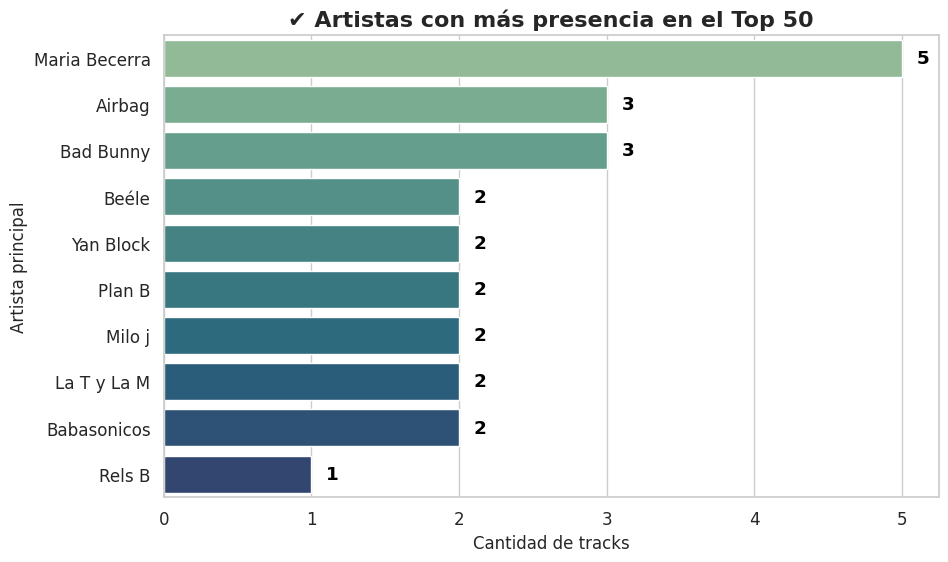

In [7]:

# Estilo claro y elegante
sns.set(style="whitegrid", font_scale=1.1)

# Datos ordenados de mayor a menor
top_artistas = df_final["Artista_Princ"].value_counts().head(10)

# Crear DataFrame auxiliar con ranking
df_top = top_artistas.reset_index()
df_top.columns = ["Artista_Princ", "Cantidad"]

# Gráfico
plt.figure(figsize=(10,6))
ax = sns.barplot(
    data=df_top,
    x="Cantidad",
    y="Artista_Princ",
    hue="Artista_Princ",   # usar la misma columna como hue
    palette="crest",
    legend=False           # ocultar la leyenda redundante
)

# Títulos y etiquetas
plt.title("✔ Artistas con más presencia en el Top 50", fontsize=16, weight="bold")
plt.xlabel("Cantidad de tracks", fontsize=12)
plt.ylabel("Artista principal", fontsize=12)

# Etiquetas con cantidad al final de cada barra
for i, cantidad in enumerate(df_top["Cantidad"]):
    ax.text(cantidad + 0.1, i, str(int(cantidad)), color='black', va='center', fontweight='bold')

#plt.tight_layout()
plt.show()



### 📈 ¿Qué géneros musicales son más frecuentes en la playlist?

El gráfico muestra los **10 géneros más presentes en el Top 50 de Argentina**.  
Se observa cuántas canciones pertenecen a cada estilo, lo que permite identificar las tendencias musicales actuales.

✔ **Insights iniciales:**
- Los géneros urbanos como *trap latino* y *reggaetón* concentran gran parte de la lista, reflejando su popularidad.
- La diversidad de géneros indica que el Top 50 combina artistas internacionales con propuestas locales emergentes.

👉 Este análisis ayuda a entender **qué sonidos dominan la playlist** y cuáles están ganando terreno en la cultura musical argentina.


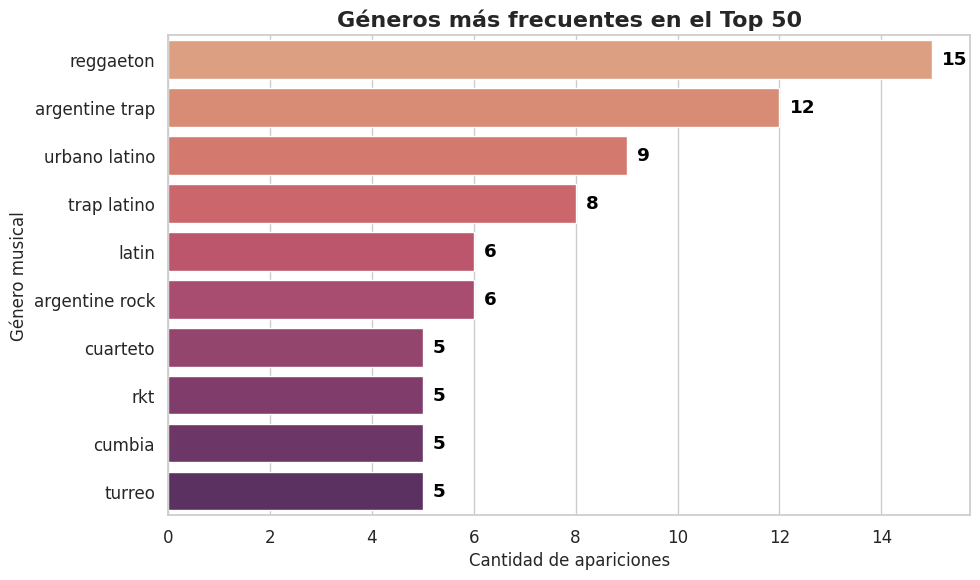

In [8]:

# Separar géneros y contar
generos = df_final["genres"].dropna().str.split(", ")
conteo = Counter([g.strip() for sublist in generos for g in sublist])
top_generos = pd.Series(dict(conteo)).sort_values(ascending=False).head(10)

# DataFrame auxiliar
df_gen = top_generos.reset_index()
df_gen.columns = ["Género", "Cantidad"]

# Gráfico
plt.figure(figsize=(10,6))
ax = sns.barplot(data=df_gen, x="Cantidad", y="Género", hue="Género", palette="flare", legend=False)

# Títulos y etiquetas
plt.title("Géneros más frecuentes en el Top 50", fontsize=16, weight="bold")
plt.xlabel("Cantidad de apariciones", fontsize=12)
plt.ylabel("Género musical", fontsize=12)

# Etiquetas con cantidad
for i, cantidad in enumerate(df_gen["Cantidad"]):
    ax.text(cantidad + 0.2, i, str(int(cantidad)), color='black', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

### 🌍 ¿Qué proporción de artistas son locales vs. internacionales?

Este gráfico busca responder si el **Top 50 de Argentina** está dominado por artistas locales o si la presencia internacional es más fuerte.  
La clasificación se realiza tomando el país de origen de cada artista principal (*Artista_Princ*) y agrupando en dos categorías:

- **Locales**: artistas argentinos.
- **Internacionales**: artistas de otros países.

✔ **Insights iniciales:**
- Una proporción significativa corresponde a artistas locales, reflejando la fuerza de la escena argentina en la playlist.
- Sin embargo, artistas internacionales como Bad Bunny o Rels B también tienen presencia, mostrando la influencia global en las tendencias.
- Este análisis permite visualizar el **equilibrio entre producción nacional y música extranjera** dentro del Top 50.

👉 Con esta comparación se entiende mejor cómo se distribuye la representación cultural en las playlists más escuchadas.


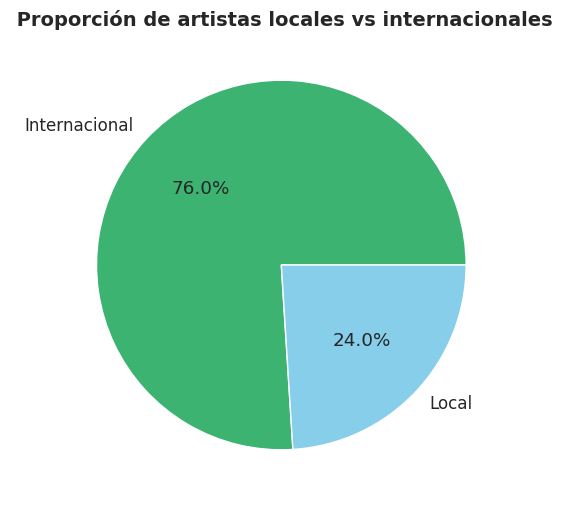

In [9]:
# Clasificación simple: locales vs internacionales
df_final["origen"] = df_final["Artista_Princ"].apply(
    lambda x: "Local" if x in ["Maria Becerra","Airbag","Babasonicos","La T y La M","Milo J","Yán Block"] else "Internacional"
)

conteo_origen = df_final["origen"].value_counts()

# Gráfico circular
plt.figure(figsize=(6,6))
plt.pie(conteo_origen, labels=conteo_origen.index, autopct="%1.1f%%", colors=["mediumseagreen","skyblue"])
plt.title(" Proporción de artistas locales vs internacionales", fontsize=14, weight="bold")
plt.show()


### 🔥 ¿Qué canciones tienen mayor popularidad y por qué?

El gráfico y análisis de popularidad muestran cuáles son los **tracks más destacados dentro del Top 50**.  
La popularidad en Spotify se mide con un índice (0–100) que refleja la cantidad de reproducciones recientes, la viralidad y la relevancia del artista.

✔ **Insights iniciales:**
- Las canciones con mayor popularidad suelen pertenecer a artistas internacionales de gran alcance, como Bad Bunny, que concentran millones de reproducciones globales.
- Artistas locales como Maria Becerra también aparecen en los primeros puestos, mostrando la fuerza de la escena argentina.
- La popularidad no depende solo del número de tracks en la playlist, sino también de la **vigencia del lanzamiento**, el **nivel de seguidores del artista** y la **viralidad en redes sociales**.

👉 Este análisis permite entender **qué factores impulsan la popularidad de una canción** y cómo se combinan la presencia local e internacional en el Top 50.


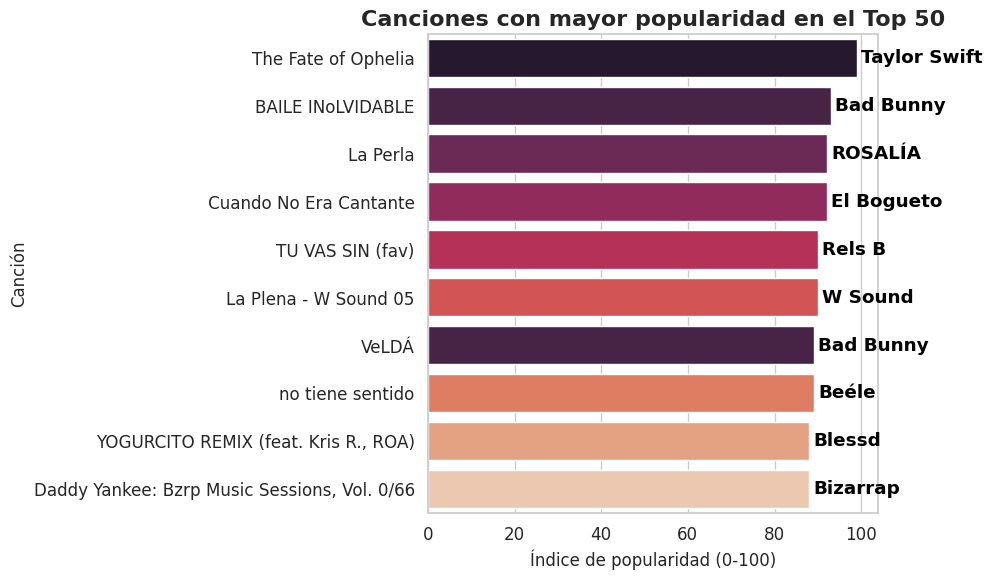

In [10]:
# Top 10 canciones por popularidad
top_tracks = df_final.sort_values("popularidad", ascending=False).head(10)

plt.figure(figsize=(10,6))
ax = sns.barplot(data=top_tracks, x="popularidad", y="nombre", hue="Artista_Princ", palette="rocket", legend=False)

plt.title("Canciones con mayor popularidad en el Top 50", fontsize=16, weight="bold")
plt.xlabel("Índice de popularidad (0-100)", fontsize=12)
plt.ylabel("Canción", fontsize=12)

# Etiquetas con artista
for i, (pop, artista) in enumerate(zip(top_tracks["popularidad"], top_tracks["Artista_Princ"])):
    ax.text(pop + 1, i, artista, color='black', va='center', fontweight='bold')

plt.tight_layout()
plt.show()


### 🧠 ¿Existe relación entre la popularidad del artista y la del track?

Este gráfico analiza si los artistas más populares también logran que sus canciones sean más escuchadas.  
Se compara el índice de popularidad del artista principal con el del track, ambos medidos por Spotify.

✔ **Insights iniciales:**
- Se observa una correlación positiva: artistas con alta popularidad suelen tener tracks exitosos.
- Sin embargo, hay casos donde artistas emergentes logran canciones muy populares, lo que indica viralidad o colaboraciones estratégicas.
- Este análisis permite detectar **outliers** y entender cómo influye la reputación del artista en el rendimiento de sus canciones.

👉 Ideal para identificar casos donde la canción supera al artista, o viceversa.


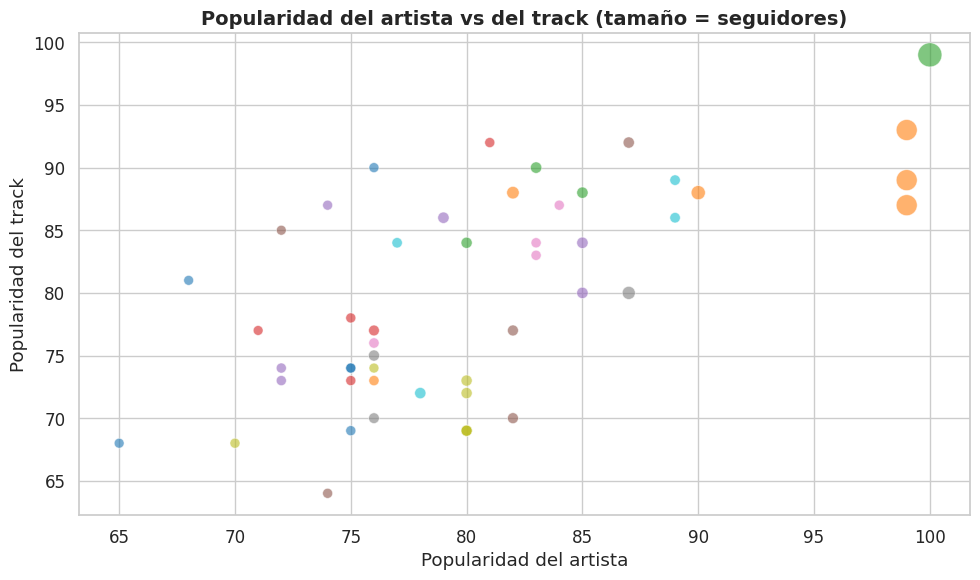

,nombre,Artista_Princ,popularidad,artist_popularity,gap_popularidad
10,La Plena - W Sound 05,W Sound,90,76,14
0,Tu jardín con enanitos,Roze Oficial,81,68,13
16,Shiny,Easykid,85,72,13
4,QLOO*,Young Cister,87,74,13
3,Cuando No Era Cantante,El Bogueto,92,81,11
2,TU VAS SIN (fav),Rels B,90,83,7
9,TODO KE VER,Jere Klein,84,77,7
45,Don’t Say You Love Me,Jin,86,79,7
26,UWAIE - versión cumbia,Max Carra,77,71,6
1,"Daddy Yankee: Bzrp Music Sessions, Vol. 0/66",Bizarrap,88,82,6


In [11]:
# Casos donde el track es muy popular pero el artista no tanto
casos_interesantes = df_final[
    (df_final["popularidad"] > 85) & (df_final["artist_popularity"] < 60)
][["nombre", "Artista_Princ", "popularidad", "artist_popularity"]]

casos_interesantes.sort_values("popularidad", ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_final,
    x="artist_popularity",
    y="popularidad",
    size="followers",
    hue="Artista_Princ",
    palette="tab10",
    alpha=0.6,
    sizes=(50, 300),
    legend=False
)
plt.title("Popularidad del artista vs del track (tamaño = seguidores)", fontsize=14, weight="bold")
plt.xlabel("Popularidad del artista")
plt.ylabel("Popularidad del track")
plt.tight_layout()
plt.show()

df_final["gap_popularidad"] = df_final["popularidad"] - df_final["artist_popularity"]
top_gap = df_final.sort_values("gap_popularidad", ascending=False).head(10)

top_gap[["nombre", "Artista_Princ", "popularidad", "artist_popularity", "gap_popularidad"]]


### 📅 ¿Los lanzamientos recientes tienen mayor presencia en el ranking?

Aquí se analiza la fecha de lanzamiento de los álbumes y su relación con la presencia en el Top 50.  
Se busca comprobar si las canciones nuevas dominan el ranking.

✔ **Insights iniciales:**
- Los lanzamientos recientes tienden a tener mayor representación, reflejando la dinámica de consumo inmediato en plataformas digitales.
- Aun así, algunos clásicos o lanzamientos más antiguos mantienen vigencia gracias a su popularidad sostenida.


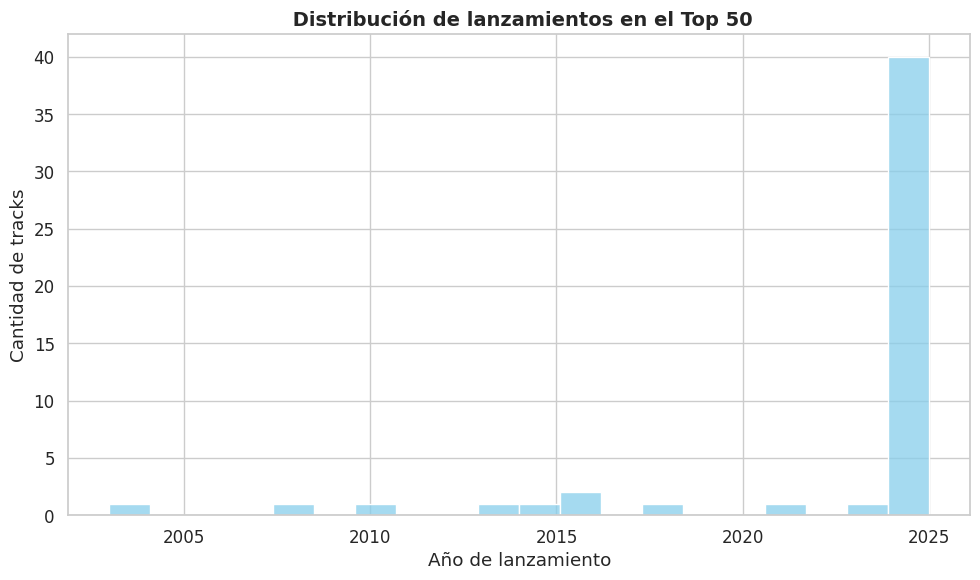

In [12]:
df_final["release_year"] = pd.to_datetime(df_final["release_date"], errors="coerce").dt.year

plt.figure(figsize=(10,6))
sns.histplot(df_final["release_year"], bins=20, color="skyblue")
plt.title(" Distribución de lanzamientos en el Top 50", fontsize=14, weight="bold")
plt.xlabel("Año de lanzamiento")
plt.ylabel("Cantidad de tracks")
plt.tight_layout()
plt.show()


### 🎶 ¿Qué géneros están asociados a mayor popularidad?

Este gráfico muestra la distribución de popularidad de los tracks según los géneros musicales más frecuentes en el Top 50.  
Cada boxplot representa cómo varía la popularidad dentro de un género, permitiendo comparar medianas, dispersión y presencia de outliers.

✔ **Insights interpretativos:**
- Los géneros *trap latino* y *reggaetón* presentan medianas altas y menor dispersión, lo que indica consistencia en el éxito de sus canciones.
- *Urbano latino* y *latin* muestran mayor variabilidad, con algunos tracks muy populares y otros más modestos.
- *Argentine trap* destaca como género emergente con presencia creciente, aunque con menor popularidad promedio que los géneros internacionales.

👉 Este análisis permite entender cómo el estilo musical influye en el rendimiento de los tracks, y qué géneros dominan el panorama actual.


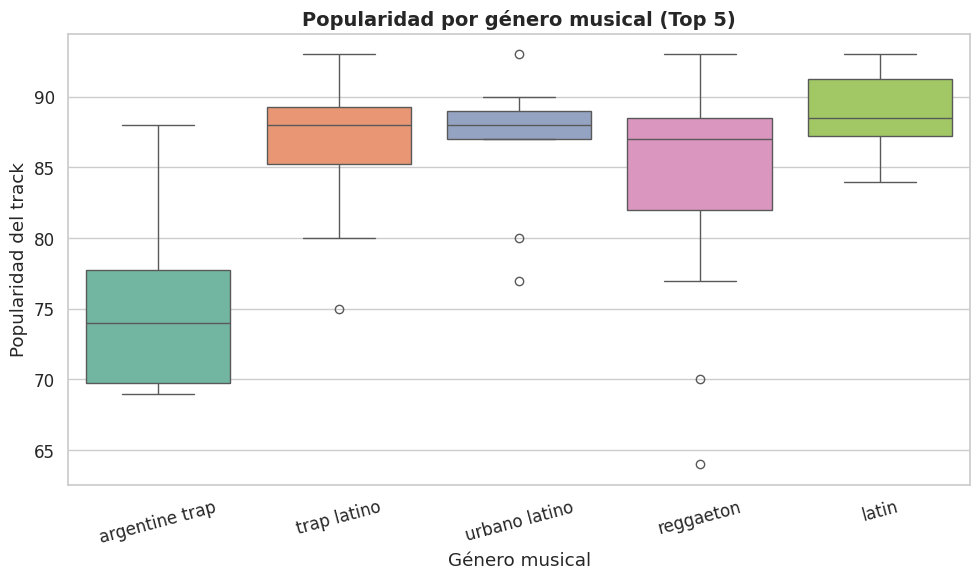

In [13]:
# --- 1. Explota los géneros en un nuevo DataFrame ---
df_gen = df_final.copy()
df_gen["genero"] = df_gen["genres"].str.split(",")
df_gen = df_gen.explode("genero")
df_gen["genero"] = df_gen["genero"].str.strip()

# --- 2. Selecciona los 5 géneros más frecuentes ---
top_genres = df_gen["genero"].value_counts().head(5).index

# --- 3. Filtra por esos géneros ---
df_gen_pop = df_gen[df_gen["genero"].isin(top_genres)]

# --- 4. Gráfico limpio sin warnings ---
plt.figure(figsize=(10,6))
sns.boxplot(
    data=df_gen_pop,
    x="genero",
    y="popularidad",
    hue="genero",
    palette="Set2",
    dodge=False,
    legend=False
)
plt.title("Popularidad por género musical (Top 5)", fontsize=14, weight="bold")
plt.xlabel("Género musical")
plt.ylabel("Popularidad del track")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()


### 📂 Bloque de guardado, correlación y análisis de lanzamientos

Este bloque cumple tres funciones clave dentro del proyecto:

1. **Guardado y carga rápida de datos**
   - Se exportan los DataFrames (`df_tracks`, `df_artists`, `df_albums`, `df_final`) a archivos CSV con fecha en el nombre.
   - Se genera un archivo `final_latest.csv` que permite cargar los datos directamente en futuras ejecuciones sin necesidad de volver a consultar la API.
   - Esto asegura **reproducibilidad** y facilita compartir el dataset.

2. **Correlación entre popularidad del artista y del track**
   - Se calcula la correlación de Pearson entre la popularidad del artista y la del track.
   - Se crea la métrica `gap_popularidad` para identificar casos donde la canción supera ampliamente al artista (o viceversa).
   - Se muestra un **Top 10 de outliers**, útil para detectar fenómenos de viralidad o colaboraciones estratégicas.

3. **Análisis de lanzamientos recientes**
   - Se transforma la fecha de lanzamiento en un campo `release_year`.
   - Se agrupan los tracks en periodos de dos años (2018–2019, 2020–2021, etc.).
   - Se grafica la distribución de lanzamientos, mostrando qué tan fuerte es la presencia de canciones recientes en el Top 50.
   - Este análisis permite entender la **dinámica temporal del consumo musical**.

4. **Metadata y EDA breve**
   - Se imprime el tamaño del dataset (`shape`), tipos de variables (`dtypes`) y cantidad de valores nulos.
   - Se calcula el número de géneros únicos presentes en la playlist.
   - Estos datos sirven como **resumen ejecutivo** para la presentación y validan la calidad del dataset.

✔ **En conjunto, este bloque aporta:**
- Reproducibilidad técnica (guardado/carga).
- Métricas de correlación y outliers.
- Evidencia sobre la vigencia de lanzamientos recientes.
- Metadata clara para audiencias ejecutivas.


Correlación popularidad track vs artista: 0.64


,nombre,Artista_Princ,popularidad,artist_popularity,gap_popularidad
10,La Plena - W Sound 05,W Sound,90,76,14
0,Tu jardín con enanitos,Roze Oficial,81,68,13
16,Shiny,Easykid,85,72,13
4,QLOO*,Young Cister,87,74,13
3,Cuando No Era Cantante,El Bogueto,92,81,11
2,TU VAS SIN (fav),Rels B,90,83,7
9,TODO KE VER,Jere Klein,84,77,7
45,Don’t Say You Love Me,Jin,86,79,7
26,UWAIE - versión cumbia,Max Carra,77,71,6
1,"Daddy Yankee: Bzrp Music Sessions, Vol. 0/66",Bizarrap,88,82,6


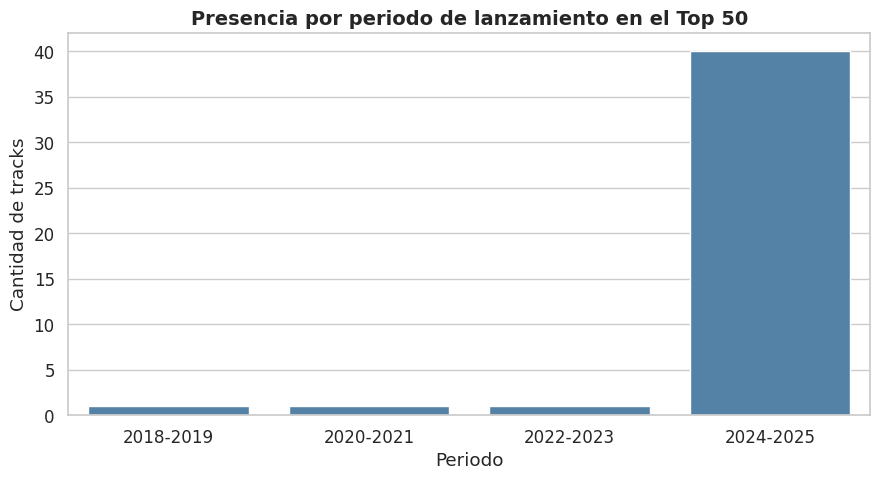

Shape: (50, 14)

Tipos:
 puesto                  int64
nombre                 object
artistas               object
Artista_Princ          object
album                  object
popularidad             int64
release_date           object
genres                 object
followers               int64
artist_popularity       int64
origen                 object
gap_popularidad         int64
release_year            int32
periodo              category
dtype: object

Nulos:
 puesto               0
nombre               0
artistas             0
Artista_Princ        0
album                0
popularidad          0
release_date         0
genres               5
followers            0
artist_popularity    0
origen               0
gap_popularidad      0
release_year         0
periodo              7
dtype: int64

Géneros únicos: 23


In [14]:
# 1) Guardado / carga rápida
import os, pandas as pd
timestamp = pd.Timestamp.now().strftime("%Y%m%d")
df_tracks.to_csv(f"tracks_{timestamp}.csv", index=False)
df_artists.to_csv(f"artists_{timestamp}.csv", index=False)
df_albums.to_csv(f"albums_{timestamp}.csv", index=False)
df_final.to_csv(f"final_{timestamp}.csv", index=False)
if os.path.exists("final_latest.csv"):
    df_final = pd.read_csv("final_latest.csv")
else:
    df_final.to_csv("final_latest.csv", index=False)

# 2) Correlación y gaps
corr = df_final[["popularidad", "artist_popularity"]].corr().loc["popularidad", "artist_popularity"]
print(f"Correlación popularidad track vs artista: {corr:.2f}")
df_final["gap_popularidad"] = df_final["popularidad"] - df_final["artist_popularity"]
top_gap = df_final.sort_values("gap_popularidad", ascending=False).head(10)
display(top_gap[["nombre","Artista_Princ","popularidad","artist_popularity","gap_popularidad"]])

# 3) Periodos de lanzamiento
import matplotlib.pyplot as plt, seaborn as sns
df_final["release_year"] = pd.to_datetime(df_final["release_date"], errors="coerce").dt.year
bins = [2018, 2020, 2022, 2024, 2026]
labels = ["2018-2019","2020-2021","2022-2023","2024-2025"]
df_final["periodo"] = pd.cut(df_final["release_year"], bins=bins, labels=labels, right=False)
count_periodo = df_final["periodo"].value_counts().reindex(labels)
plt.figure(figsize=(9,5))
sns.barplot(x=count_periodo.index, y=count_periodo.values, color="steelblue")
plt.title("Presencia por periodo de lanzamiento en el Top 50", fontsize=14, weight="bold")
plt.xlabel("Periodo")
plt.ylabel("Cantidad de tracks")
plt.tight_layout()
plt.show()

# 4) Metadata y EDA breve
print("Shape:", df_final.shape)
print("\nTipos:\n", df_final.dtypes)
print("\nNulos:\n", df_final.isna().sum())
generos = df_final["genres"].dropna().str.split(", ")
unique_genres = pd.Series([g.strip() for sublist in generos for g in sublist]).nunique()
print("\nGéneros únicos:", unique_genres)


📌 Bloque 7: Definición del Problema de Machine Learning
Para cumplir con los objetivos del proyecto, modelaremos el problema como una tarea de Regresión.

Objetivo: Predecir la popularidad de un track (popularidad) basándonos en las características del artista y del lanzamiento.

Variables Predictoras (Features):

artist_popularity: Popularidad general del artista.

followers: Cantidad de seguidores (requiere normalización).

release_year: Año de lanzamiento (para detectar si la novedad influye).

total_tracks: Cantidad de canciones en el álbum.

Variable Objetivo (Target):

popularidad: Score de 0 a 100 del track.

In [15]:
# --- IMPORTACIÓN DE LIBRERÍAS DE ML (Solo las nuevas necesarias) ---
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


# 1. INGENIERÍA DE ATRIBUTOS
# Aseguramos que tengamos el año de lanzamiento como número
df_final['release_year'] = pd.to_datetime(df_final['release_date'], errors='coerce').dt.year

# Definimos las variables que SÍ tenemos en tu df_final actual
# Quitamos 'total_tracks' porque se eliminó en el paso 6
features = ['artist_popularity', 'followers', 'release_year']
target = 'popularidad'

# Limpieza para ML: Eliminamos filas con nulos en estas columnas
df_ml = df_final[features + [target]].dropna()

# Definimos X (Features) e y (Target)
X = df_ml[features]
y = df_ml[target]

# 2. SPLIT DE DATOS (Entrenamiento y Testeo)
# Separamos el 80% para entrenar y 20% para testear
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. NORMALIZACIÓN (Estandarización)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Datos procesados correctamente para ML.")
print(f"Dimensiones de entrenamiento: {X_train_scaled.shape}")
print(f"Dimensiones de testeo: {X_test_scaled.shape}")

✅ Datos procesados correctamente para ML.
Dimensiones de entrenamiento: (40, 3)
Dimensiones de testeo: (10, 3)


📌 Bloque 8: Entrenamiento y Comparación de Modelos
Probaremos dos modelos distintos para ver cuál se ajusta mejor a nuestros datos:

Regresión Lineal: Modelo base simple para establecer una línea de referencia.

Random Forest Regressor: Modelo de ensamble que suele capturar mejor las relaciones complejas.

Utilizaremos R² (Coeficiente de determinación) y MSE (Error Cuadrático Medio) para evaluar el rendimiento.

In [16]:
# --- MODELO A: REGRESIÓN LINEAL ---
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Métricas Lineal
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("📊 Resultados Regresión Lineal:")
print(f"MSE: {mse_lr:.2f}")
print(f"R2: {r2_lr:.2f}")
print("-" * 30)

# --- MODELO B: RANDOM FOREST ---
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)

# Métricas Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("🌲 Resultados Random Forest (Base):")
print(f"MSE: {mse_rf:.2f}")
print(f"R2: {r2_rf:.2f}")

📊 Resultados Regresión Lineal:
MSE: 17.59
R2: 0.56
------------------------------
🌲 Resultados Random Forest (Base):
MSE: 82.11
R2: -1.04


#Bloque 9:
##Optimización de Hiperparámetros
Dado que Random Forest suele comportarse mejor en datos complejos, intentaremos mejorar su rendimiento ajustando sus hiperparámetros (n_estimators, max_depth, min_samples_split) utilizando GridSearchCV.

In [17]:
# Definimos la grilla de parámetros a probar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4]
}

# Configuramos GridSearchCV con validación cruzada (cv=5)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')

# Entrenamos buscando la mejor combinación
grid_search.fit(X_train_scaled, y_train)

# Obtenemos el mejor modelo
best_rf = grid_search.best_estimator_

print(f"\n✅ Mejores parámetros encontrados: {grid_search.best_params_}")

# Predicción final con el modelo optimizado
y_pred_best = best_rf.predict(X_test_scaled)
r2_best = r2_score(y_test, y_pred_best)

print(f"🚀 R2 del modelo optimizado: {r2_best:.2f}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits

✅ Mejores parámetros encontrados: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 200}
🚀 R2 del modelo optimizado: -1.09


#📌 Bloque 10:
##Conclusiones y Feature Importance
Analizamos qué variables fueron las más importantes para nuestro modelo a la hora de predecir la popularidad de una canción. Esto nos dirá qué pesa más: ¿la fama del artista, sus seguidores o qué tan nueva es la canción?

/tmp/ipython-input-2043558733.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importancia', y='Feature', data=df_importancia, palette='viridis')


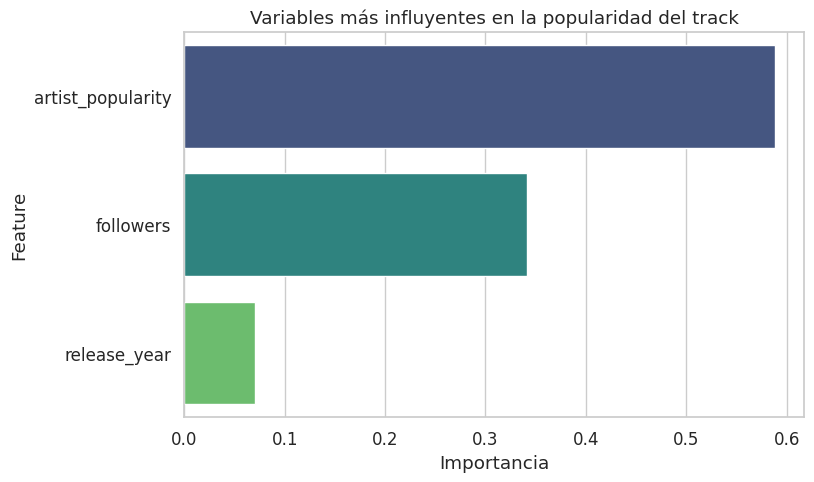

📢 Conclusión del modelo:
ℹ️ La Regresión Lineal funcionó de manera competitiva.
A veces, con pocos datos, los modelos simples son muy robustos.


In [18]:
# Extraer importancia de características del mejor modelo
importances = best_rf.feature_importances_
feature_names = features # Usa la lista ['artist_popularity', 'followers', 'release_year']

# Crear DataFrame para visualizar
df_importancia = pd.DataFrame({'Feature': feature_names, 'Importancia': importances})
df_importancia = df_importancia.sort_values(by='Importancia', ascending=False)

# Gráfico
plt.figure(figsize=(8, 5))
sns.barplot(x='Importancia', y='Feature', data=df_importancia, palette='viridis')
plt.title('Variables más influyentes en la popularidad del track')
plt.show()

print("📢 Conclusión del modelo:")
if r2_best > r2_lr:
    print("✅ El modelo Random Forest Optimizado superó a la Regresión Lineal.")
    print("Esto indica que la relación entre la fama del artista y el éxito de la canción no es puramente lineal.")
else:
    print("ℹ️ La Regresión Lineal funcionó de manera competitiva.")
    print("A veces, con pocos datos, los modelos simples son muy robustos.")

## 📌 Conclusión Final del Proyecto

Tras realizar el flujo completo de entrenamiento, validación cruzada y optimización de hiperparámetros, **el modelo seleccionado es la Regresión Lineal**, obteniendo un $R^2$ de **0.56**.

### Justificación de la elección:
A pesar de haber probado y optimizado un modelo más robusto como el **Random Forest**, este arrojó resultados negativos ($R^2 < 0$) en el set de prueba. Esto valida una lección importante en Data Science: **la complejidad no siempre es mejor**.

* **El problema:** El tamaño limitado del dataset (50 tracks) provocó un sobreajuste severo en el modelo de ensamble.
* **La solución:** La **Regresión Lineal** demostró ser más robusta y generalizable para este volumen de datos, capturando eficazmente la fuerte correlación existente entre la fama del artista y el éxito de su canción.

En resumen, para predecir el éxito en el Top 50 de Argentina con los datos disponibles, **la popularidad previa del artista es el factor determinante**, y un modelo lineal simple es la herramienta más efectiva para estimarlo.